In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.driver.memory", "15g") \
    .appName("ECG") \
    .getOrCreate()

sc = spark.sparkContext

23/05/11 17:41:56 WARN Utils: Your hostname, filip.local resolves to a loopback address: 127.0.0.1; using 10.15.176.160 instead (on interface en0)
23/05/11 17:41:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/11 17:41:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/11 17:41:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/11 17:41:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
import math

oversampling = True
train_part_num = 10
test_part_num = 1
k = 1
in_k = max(math.floor(k/train_part_num), 1)

In [3]:
if not oversampling:
    # df = spark.read.csv("abfss://team6@sauondbrwebigdatalrs1.dfs.core.windows.net/ECG5000/ECG5000_TRAIN.tsv",sep=r'\t', header=True)
    train_df = spark.read.csv("../data/ECG5000/ECG5000_TRAIN.tsv", sep='\t', header=False)
    test_df = spark.read.csv("../data/ECG5000/ECG5000_TEST.tsv" ,sep='\t', header=False)

In [4]:
from pyspark.sql.functions import rand

if not oversampling:    
    train_df = train_df.orderBy(rand()) #.limit(100)
    test_df = test_df.orderBy(rand()) #.limit(50)

In [5]:
from pyspark.sql.functions import col

if not oversampling:    
    train_df = train_df.withColumnRenamed("_c0", "Class")
    test_df = test_df.withColumnRenamed("_c0", "Class")

    for col_name in train_df.columns[1:]:
        if col_name != "Class":
            train_df = train_df.withColumn(col_name, col(col_name).cast("float"))

    for col_name in test_df.columns[1:]:
        if col_name != "Class":
            test_df = test_df.withColumn(col_name, col(col_name).cast("float"))

    # Append the rows from test_df to train_df
    merged_df = train_df.union(test_df)

In [6]:
if oversampling:
    merged_df = spark.read.csv("../data/ECG5000/ECG5000_Oversampled.csv", header=True)
    merged_df = merged_df.orderBy(rand(seed=42))

# Show the resulting dataframe
merged_df.count()

6300

In [ ]:
merged_df = merged_df.limit(1000)

In [7]:
# Define the split ratio
train_ratio = 0.7
test_ratio = 0.3

# Split the data into train and test sets
train_df, test_df = merged_df.randomSplit([train_ratio, test_ratio], seed=346)


In [8]:
train_df.groupBy("Class").count().show()

23/05/11 17:42:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-----+
|Class|count|
+-----+-----+
|    1| 2069|
|    2| 1241|
|    3|  414|
|    5|  285|
|    4|  429|
+-----+-----+



In [2]:
train_df.count()

NameError: name 'train_df' is not defined

In [10]:
train_df.cache()
test_df.cache()

DataFrame[Class: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _c66: string, _c67: string, _c68: string, _c69: string, _c70: string, _c71

In [11]:
for df in [train_df, test_df]:
    duplicates_df = df.dropDuplicates()
    num_duplicates = df.count() - duplicates_df.count()
    if num_duplicates > 0:
        print("There are duplicate rows in the DataFrame.")
    else:
        print("There are no duplicate rows in the DataFrame.")

There are duplicate rows in the DataFrame.


There are duplicate rows in the DataFrame.


In [12]:
import pyspark.sql.functions as F
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import pandas as pd

In [13]:
train_rdd = train_df.rdd.repartition(train_part_num)
column_names = df.columns

In [14]:
def toPandas_partition(instances):
    panda_df = pd.DataFrame(columns = column_names)      # using the global variable
    
    for instance in instances:  # each instance is of Row type
        panda_df = pd.concat([panda_df, pd.DataFrame([instance.asDict()])], ignore_index=True)
  
    return [panda_df]

rdd_pandas = train_rdd.mapPartitions(toPandas_partition)

In [15]:
import random

def build_model(partition):

    knn = KNeighborsTimeSeriesClassifier(n_neighbors=in_k, metric='dtw')
    
    X_train = partition.drop('Class', axis=1)
    y_train = partition['Class']
    
    model = knn.fit(X_train, y_train)

    return model

model = rdd_pandas.map(build_model).collect()

In [16]:
test_rdd  = test_df.rdd.repartition(test_part_num)
test_rdd_pandas = test_rdd.mapPartitions(toPandas_partition)

In [17]:
def test_classifier(partition):
    predictions = []
    distances = []
    X_test = partition.drop('Class', axis=1).values
    
    for m in model:
        neighbors = m.kneighbors(X_test)
        pred = m.predict(X_test).tolist()
        distances.append(neighbors[0].tolist())
        predictions.append(pred)

    return predictions, distances

def get_majority_vote(predictions):
    return max(set(predictions), key=predictions.count)

def predict_class(partition):
    predictions, distances = test_classifier(partition)
    predicted_labels = []

    for i in range(len(predictions[0])):
        class_votes = []
        dist_votes = []
        for j in range(len(predictions)):
            class_votes.append(predictions[j][i])
            dist_votes.append(distances[j][i])

        k_nearest = sorted(zip(dist_votes, class_votes), key=lambda x: x[0])[:k]
        majority_class = get_majority_vote([x[1] for x in k_nearest])
        # print("CLASS VOTES:\n", class_votes)
        # print("MAJORITY CLASS:", majority_class)
        predicted_labels.append(majority_class)

    return predicted_labels

predictions = test_rdd_pandas.map(predict_class).flatMap(lambda x: x)

In [18]:
y_pred = predictions.collect()

In [19]:
y_test = test_df.select("Class").collect()

In [20]:
from pyspark.sql.functions import when, count

y_pred_df = spark.createDataFrame([(i,) for i in y_pred], ['prediction'])
y_test_df = spark.createDataFrame(y_test, ['Class'])

In [21]:
from pyspark.sql.functions import monotonically_increasing_id

y_pred_df = y_pred_df.withColumn("id", monotonically_increasing_id())
y_test_df = y_test_df.withColumn("id", monotonically_increasing_id())

joined_df = y_pred_df.join(y_test_df, "id", "outer").drop("id")

joined_df = joined_df.withColumn('same_values', when(joined_df.prediction == joined_df.Class, 1).otherwise(0))

print("joined_df:")
joined_df.show(100)

joined_df:


+----------+-----+-----------+
|prediction|Class|same_values|
+----------+-----+-----------+
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|       

In [22]:
percentage_same_values = joined_df.agg({'same_values': 'mean'}).collect()[0][0] * 100

print(f"{percentage_same_values:.2f}% of rows have the same label and prediction.")

86.63% of rows have the same label and prediction.


In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

indexed_df = joined_df.withColumn("ClassIndex", col("Class").cast("integer"))

# Cast the prediction column to DoubleType
indexed_df = indexed_df.withColumn("prediction", col("prediction").cast("double"))

# Compute F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="ClassIndex", metricName="f1")
f1_score = evaluator.evaluate(indexed_df)
print(f"F1 score: {f1_score:.2f}")

F1 score: 0.87


In [24]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

indexed_df = indexed_df.withColumn("ClassIndexDb", col("ClassIndex").cast("double"))

# Calculate the confusion matrix
predictions_and_labels = indexed_df.select(["prediction", "ClassIndexDb"]).rdd
metrics = MulticlassMetrics(predictions_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()

# Define list of class labels
classes = ['1', '2', '3', '4', '5']

/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


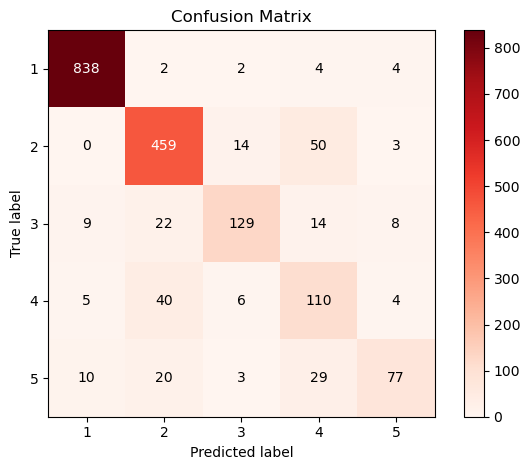

23/05/11 20:35:04 WARN TransportChannelHandler: Exception in connection from /10.15.176.160:49494
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:356)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:719)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpt

In [25]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Reds')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Loop over data dimensions and create text annotations.
thresh = confusion_matrix.max() / 2.
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.tight_layout()
plt.show()